#Scraps Type Classification using Convolutional Neural Network (CNN)

##1. Import Library and Dataset

In [ ]:
import os
import zipfile
import shutil
from shutil import copyfile
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")
print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/Shareddrives/recycraft/scraps-dataset"
%cd /content/drive/Shareddrives/recycraft/scraps-dataset/

Mounted at /content/drive
/content/drive/Shareddrives/recycraft/scraps-dataset


In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification
!kaggle datasets download -d ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects
!kaggle datasets download -d techsash/waste-classification-data

garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
most-common-recyclable-and-nonrecyclable-objects.zip: Skipping, found more recently modified local copy (use --force to force download)
waste-classification-data.zip: Skipping, found more recently modified local copy (use --force to force download)


##2. Settings Hyperparameter

In [ ]:
SPLIT_SIZE = 0.9
BATCH_SIZE = 32
INPUT_SIZE = (150, 150)
EPOCH = 20
N = 16

##3. Create Training & Validation Directory

In [ ]:
root_path = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification'

def create_train_val_dirs(root_path):
  training_dir = os.path.join(root_path, "training")
  validation_dir = os.path.join(root_path, "validation")
  os.makedirs(training_dir)
  os.makedirs(validation_dir)
  os.makedirs(os.path.join(training_dir, "organic"))
  os.makedirs(os.path.join(training_dir, "recycleable"))
  os.makedirs(os.path.join(validation_dir, "organic"))
  os.makedirs(os.path.join(validation_dir, "recycleable"))
try:
  create_train_val_dirs(root_path)
  print("Succesfull !")
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

for rootdir, dirs, files in os.walk(root_path):
  for subdir in dirs:
    print(os.path.join(rootdir, subdir))

You should not be seeing this since the upper directory is removed beforehand
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training/organic
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training/recycleable
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation/organic
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation/recycleable


##4. Splitting Dataset

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(f"{filename} memiliki ukuran 0 sehingga dilewatkan.")
      
  training_len = int(len(files) * SPLIT_SIZE)
  validation_len = int(len(files) - training_len)
  shuffle_set = random.sample(files, len(files))
  training_set = shuffle_set[0:training_len]
  validation_set = shuffle_set[-validation_len:]
  
  for filename in training_set:
    source = SOURCE + filename
    destiny = TRAINING + filename
    copyfile(source, destiny)

  for filename in validation_set:
    source = SOURCE + filename
    destiny = VALIDATION + filename
    copyfile(source, destiny)

In [ ]:
#source path
organic_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/organic/'
recycleable_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/recycleable/'

#training & testing path
training_dir = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training/'
validation_dir = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation/'

#destiny path
organic_training_dir = os.path.join(training_dir, 'organic/')
organic_validation_dir = os.path.join(validation_dir, 'organic/')
recycleable_training_dir = os.path.join(training_dir, 'recycleable/')
recycleable_validation_dir = os.path.join(validation_dir, 'recycleable/')

if len(os.listdir(organic_training_dir)) > 0:
  for file in os.scandir(organic_training_dir):
    os.remove(file.path)
if len(os.listdir(organic_validation_dir)) > 0:
  for file in os.scandir(organic_validation_dir):
    os.remove(file.path)
if len(os.listdir(recycleable_training_dir)) > 0:
  for file in os.scandir(recycleable_training_dir):
    os.remove(file.path)
if len(os.listdir(recycleable_validation_dir)) > 0:
  for file in os.scandir(recycleable_validation_dir):
    os.remove(file.path)

split_data(organic_source_path, organic_training_dir, organic_validation_dir, SPLIT_SIZE)
split_data(recycleable_source_path, recycleable_training_dir, recycleable_validation_dir, SPLIT_SIZE)

print(f"\nAda {len(os.listdir(organic_training_dir))} gambar organic materials pada training ")
print(f"Ada {len(os.listdir(organic_validation_dir))} gambar organic materials pada validation ")
print(f"Ada {len(os.listdir(recycleable_training_dir))} gambar recycleable materials pada training ")
print(f"Ada {len(os.listdir(recycleable_validation_dir))} gambar recycleable materials pada validation ")


Ada 9448 gambar organic materials pada training 
Ada 1050 gambar organic materials pada validation 
Ada 9366 gambar recycleable materials pada training 
Ada 1041 gambar recycleable materials pada validation 


##5. Training Validation Generator and Data Augmentation

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest'
                                     )
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = BATCH_SIZE,
                                                      class_mode = 'categorical',
                                                      target_size = INPUT_SIZE)
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(directory =VALIDATION_DIR,
                                                                batch_size = BATCH_SIZE,
                                                                class_mode = 'categorical',
                                                                target_size = INPUT_SIZE)
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 18809 images belonging to 2 classes.
Found 2087 images belonging to 2 classes.


##6. Create Model using CNN and Implement Flatten, Dropout, and Regularization

In [ ]:
def create_model():
  model = tf.keras.models.Sequential([
      keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape= (150, 150, 3)),
      keras.layers.MaxPooling2D(2,2),
      keras.layers.Conv2D(64, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D(2,2),
      keras.layers.Conv2D(128, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D(2,2),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation="relu"),
      keras.layers.Dropout(0.25),
      keras.layers.Dense(2, activation="sigmoid")
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                      loss='binary_crossentropy',
                                                      metrics=['accuracy'])
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

##7. Training Data

In [ ]:
history = model.fit(train_generator,
                    epochs = EPOCH, 
                    validation_data = validation_generator,
                    verbose=1)

Epoch 1/20
588/588 [==============================] - 165s 260ms/step - loss: 0.4554 - accuracy: 0.7969 - val_loss: 0.4249 - val_accuracy: 0.8103
Epoch 2/20
588/588 [==============================] - 146s 249ms/step - loss: 0.4130 - accuracy: 0.8201 - val_loss: 0.3986 - val_accuracy: 0.8361
Epoch 3/20
588/588 [==============================] - 145s 247ms/step - loss: 0.3944 - accuracy: 0.8317 - val_loss: 0.3646 - val_accuracy: 0.8505
Epoch 4/20
588/588 [==============================] - 144s 244ms/step - loss: 0.3789 - accuracy: 0.8382 - val_loss: 0.4393 - val_accuracy: 0.8194
Epoch 5/20
588/588 [==============================] - 144s 244ms/step - loss: 0.3738 - accuracy: 0.8407 - val_loss: 0.3566 - val_accuracy: 0.8524
Epoch 6/20
588/588 [==============================] - 143s 244ms/step - loss: 0.3618 - accuracy: 0.8491 - val_loss: 0.3561 - val_accuracy: 0.8524
Epoch 7/20
588/588 [==============================] - 144s 245ms/step - loss: 0.3538 - accuracy: 0.8517 - val_loss: 0.3795 -

##8. Plotting Accuracy and Model Evaluation

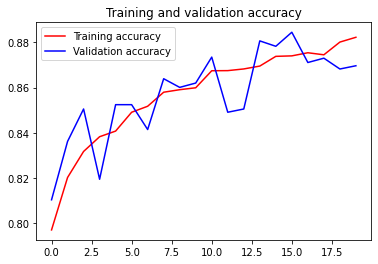

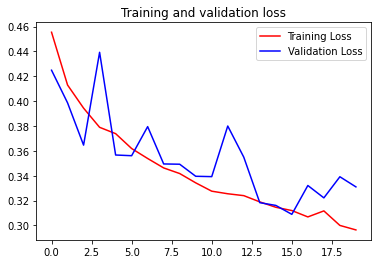

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
_, acc = model.evaluate_generator(validation_generator, steps=10, verbose=0)
print('Test Accuracy: %.3f ' % (acc * 100))

Test Accuracy: 85.312 


##9. Predict Data

Akurasi : 87.5 %


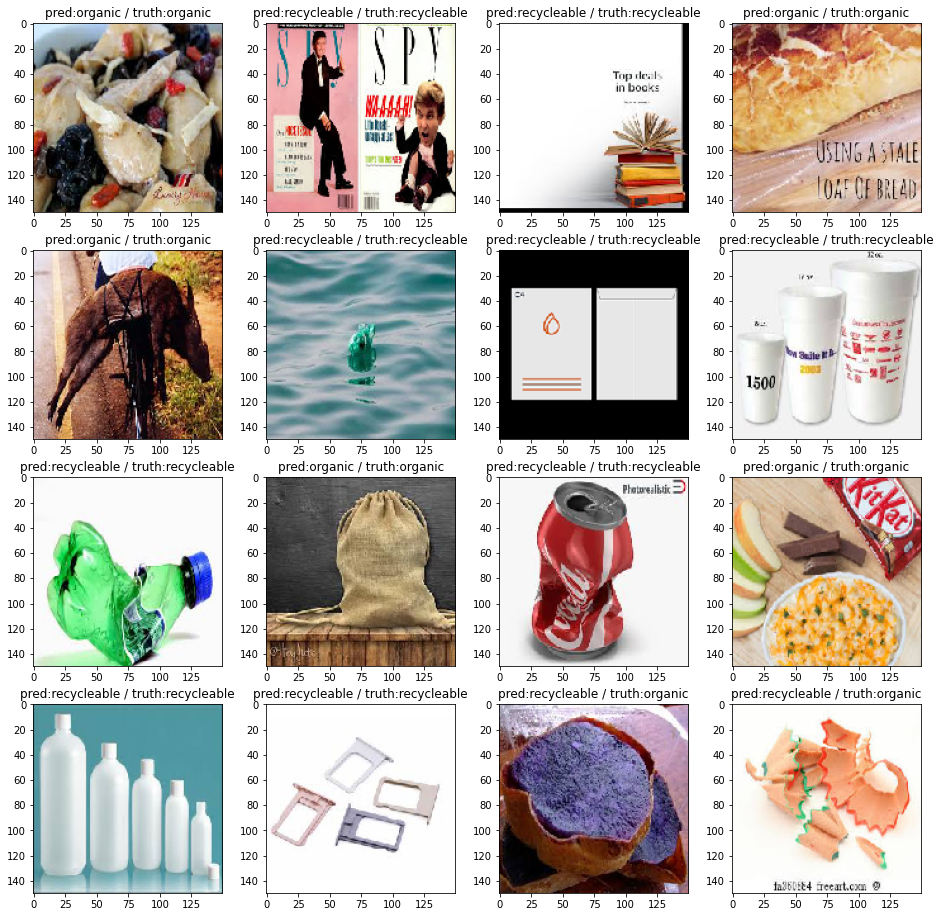

In [ ]:
test_x, test_y = validation_generator.__getitem__(1)

labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

y_pred = model.predict(test_x)

plt.figure(figsize=(16, 16))
n = 16
count = 0
for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(y_pred[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    if (np.argmax(y_pred[i]) == np.argmax(test_y[i])):
      count += 1
akurasi = count/n*100
print('Akurasi : {} %'.format(akurasi))